<h3 STYLE="background: #c2edff;padding: 0.5em;">Step 5. 機械学習で二値分類</h3>

<ol>
<li><a href="#1">「ワインの品質」データ読み込み</a>
<li><a href="#2">２群に分ける</a>
<li><a href="#3">説明変数と目的変数に分ける</a>
<li><a href="#4">訓練データとテストデータに分ける</a>
<li><a href="#5">ロジスティク回帰</a>
<li><a href="#6">いろんな機械学習手法を比較する</a>
</ol>

In [1]:
# 数値計算やデータフレーム操作に関するライブラリをインポートする
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

In [2]:
# URL によるリソースへのアクセスを提供するライブラリをインポートする。
# import urllib # Python 2 の場合
import urllib.request # Python 3 の場合

In [3]:
# 図やグラフを図示するためのライブラリをインポートする。
%matplotlib inline
import matplotlib.pyplot as plt
from pandas.tools import plotting

In [4]:
# 機械学習関連のライブラリ群

from sklearn.cross_validation import train_test_split # 訓練データとテストデータに分割
from sklearn.metrics import confusion_matrix # 混合行列

from sklearn.decomposition import PCA #主成分分析
from sklearn.linear_model import LogisticRegression # ロジスティック回帰
from sklearn.neighbors import KNeighborsClassifier # K近傍法
from sklearn.svm import SVC # サポートベクターマシン
from sklearn.tree import DecisionTreeClassifier # 決定木
from sklearn.ensemble import RandomForestClassifier # ランダムフォレスト
from sklearn.ensemble import AdaBoostClassifier # AdaBoost
from sklearn.naive_bayes import GaussianNB # ナイーブ・ベイズ
from sklearn.lda import LDA # 線形判別分析
from sklearn.qda import QDA # 二次判別分析

<h3 STYLE="background: #c2edff;padding: 0.5em;"><a name="1">1. 「ワインの品質」データ読み込み</a></h3>

データは <a href="http://archive.ics.uci.edu/ml/index.php" target="_blank">UC Irvine Machine Learning Repository</a> から取得したものを少し改変しました。

* 赤ワイン https://raw.githubusercontent.com/chemo-wakate/tutorial-6th/master/beginner/data/winequality-red.txt

* 白ワイン https://raw.githubusercontent.com/chemo-wakate/tutorial-6th/master/beginner/data/winequality-white.txt

<h4 style="border-bottom: solid 1px black;">　<a href="http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality.names">詳細</a></h4>

<ol>
<li>fixed acidity : 不揮発酸濃度（ほぼ酒石酸濃度）
<li>volatile acidity : 揮発酸濃度（ほぼ酢酸濃度）
<li>citric acid : クエン酸濃度
<li>residual sugar : 残存糖濃度
<li>chlorides : 塩化物濃度
<li>free sulfur dioxide : 遊離亜硫酸濃度
<li>total sulfur dioxide : 亜硫酸濃度
<li>density : 密度
<li>pH : pH
<li>sulphates : 硫酸塩濃度
<li>alcohol : アルコール度数
<li>quality (score between 0 and 10) : 0-10 の値で示される品質のスコア
</ol>

In [5]:
# ウェブ上のリソースを指定する
url = 'https://raw.githubusercontent.com/chemo-wakate/tutorial-6th/master/beginner/data/winequality-red.txt'
# 指定したURLからリソースをダウンロードし、名前をつける。
# urllib.urlretrieve(url, 'winequality-red.csv') # Python 2 の場合
urllib.request.urlretrieve(url, 'winequality-red.txt') # Python 3 の場合

('winequality-red.txt', <http.client.HTTPMessage at 0x109344a58>)

In [6]:
# データの読み込み
df1 = pd.read_csv('winequality-red.txt', sep='\t', index_col=0) 

In [7]:
df1.head() # 先頭５行だけ表示

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5


<h3 STYLE="background: #c2edff;padding: 0.5em;"><a name="2">2. ２群に分ける</a></h3>

ここでは、ワインの品質を「６未満（よくない）」と「６以上（よい）」の２群に分けてから、機械学習を用いて、pH や volatile acidity などの変数から品質を予測してみましょう。まずは、２群に分けることから始めます。

<h4 style="border-bottom: solid 1px black;">簡単な例で説明</h4>

データを２群に分けるにあたって、pandasの操作が少し分かりにくいので、簡単な例を用いて説明します。

In [8]:
# 簡単な例
toy_data = pd.DataFrame([[1, 4, 7, 10, 13, 16], [2, 5, 8, 11, 14, 27], [3, 6, 9, 12, 15, 17], [21, 24, 27, 20, 23, 26]],
                   index = ['i1','i2','i3', 'i4'],
                   columns = list("abcdef"))

In [9]:
toy_data # 中身の確認

,a,b,c,d,e,f
i1,1,4,7,10,13,16
i2,2,5,8,11,14,27
i3,3,6,9,12,15,17
i4,21,24,27,20,23,26


In [10]:
# F列の値が 20 未満の列だけを抜き出す
toy_data[toy_data['f'] < 20]

,a,b,c,d,e,f
i1,1,4,7,10,13,16
i3,3,6,9,12,15,17


In [11]:
# F列の値が 20 以上の列だけを抜き出す
toy_data[toy_data['f'] >= 20]

,a,b,c,d,e,f
i2,2,5,8,11,14,27
i4,21,24,27,20,23,26


In [12]:
# F列の値が 20 以上の列だけを抜き出して、そのB列を得る
pd.DataFrame(toy_data[toy_data['f'] >= 20]['b'])

,b
i2,5
i4,24


In [13]:
# classという名の列を作り、F列の値が 20 未満なら 0 を、そうでなければ 1 を入れる
toy_data['class'] = [0 if i < 20 else 1 for i in toy_data['f'].tolist()]

In [14]:
toy_data # 中身を確認

,a,b,c,d,e,f,class
i1,1,4,7,10,13,16,0
i2,2,5,8,11,14,27,1
i3,3,6,9,12,15,17,0
i4,21,24,27,20,23,26,1


<h4 style="border-bottom: solid 1px black;">実データに戻ります</h4>

以下、quality が６未満のワインと６以上のワインに分け、どのように違うのか調べてみましょう。

In [15]:
# quality が 6 未満の行を抜き出して、先頭５行を表示する
df1[df1['quality'] < 6].head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
4,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5


In [16]:
# quality が 6 以上の行を抜き出して、先頭５行を表示する
df1[df1['quality'] >= 6].head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
3,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
7,7.3,0.65,0.00,1.2,0.065,15,21,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9,18,0.9968,3.36,0.57,9.5,7
16,8.5,0.28,0.56,1.8,0.092,35,103,0.9969,3.30,0.75,10.5,7
19,7.9,0.32,0.51,1.8,0.341,17,56,0.9969,3.04,1.08,9.2,6


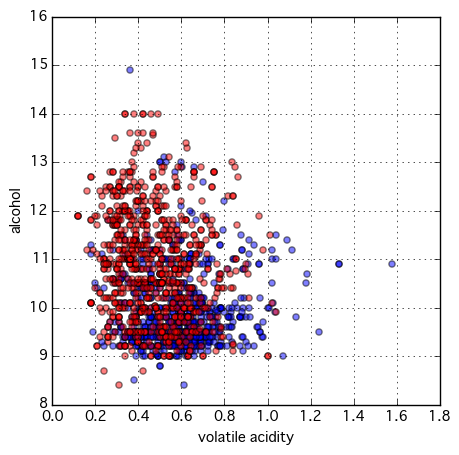

In [17]:
fig, ax = plt.subplots(1, 1)

# quality が 6 未満の行を抜き出して、x軸を volatile acidity 、 y軸を alcohol として青色の丸を散布する
df1[df1['quality'] <  6].plot(kind='scatter', x=u'volatile acidity', y=u'alcohol', ax=ax, 
                              c='blue', alpha=0.5)

# quality が 6 以上の行を抜き出して、x軸を volatile acidity 、 y軸を alcohol として赤色の丸を散布する
df1[df1['quality'] >= 6].plot(kind='scatter', x=u'volatile acidity', y=u'alcohol', ax=ax, 
                              c='red', alpha=0.5, grid=True, figsize=(5,5))
plt.show()

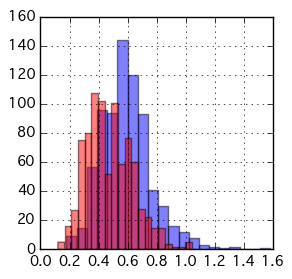

In [18]:
# quality が 6 未満のものを青色、6以上のものを赤色に彩色して volatile acidity の分布を描画
df1[df1['quality'] <  6]['volatile acidity'].hist(figsize=(3, 3), bins=20, alpha=0.5, color='blue')
df1[df1['quality'] >= 6]['volatile acidity'].hist(figsize=(3, 3), bins=20, alpha=0.5, color='red')

上図のように、qualityが６未満のワインと６以上のワインは volatile acidity の分布が異なるように見えます。その差が有意かどうか t検定 で確認してみましょう。

In [19]:
# 対応のないt検定
significance = 0.05
X = df1[df1['quality'] <  6]['volatile acidity'].tolist()
Y = df1[df1['quality'] >= 6]['volatile acidity'].tolist()

t, p = stats.ttest_ind(X, Y)

print( "t 値は %(t)s" %locals() )
print( "確率は %(p)s" %locals() )

if p < significance:
    print("有意水準 %(significance)s で、有意な差があります" %locals())
else:
    print("有意水準 %(significance)s で、有意な差がありません" %locals())

t 値は 13.5655002264
確率は 9.33662078115e-40
有意水準 0.05 で、有意な差があります


同様に、qualityが６未満のワインと６以上のワインでは pH の分布が異なるか調べてみましょう。

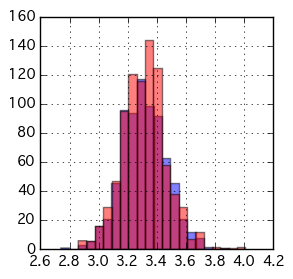

In [20]:
# quality が 6 未満のものを青色、6以上のものを赤色に彩色して pH の分布を描画
df1[df1['quality'] <  6]['pH'].hist(figsize=(3, 3), bins=20, alpha=0.5, color='blue')
df1[df1['quality'] >= 6]['pH'].hist(figsize=(3, 3), bins=20, alpha=0.5, color='red')

In [21]:
# 対応のないt検定
significance = 0.05
X = df1[df1['quality'] <= 5]['pH'].tolist()
Y = df1[df1['quality'] >  5]['pH'].tolist()

t, p = stats.ttest_ind(X, Y)

print( "t 値は %(t)s" %locals() )
print( "確率は %(p)s" %locals() )

if p < significance:
    print("有意水準 %(significance)s で、有意な差があります" %locals())
else:
    print("有意水準 %(significance)s で、有意な差がありません" %locals())

t 値は 0.130437581408
確率は 0.896236662563
有意水準 0.05 で、有意な差がありません


<h4 style="border-bottom: solid 1px black;">分類を表す列を追加する</h4>

quality が 6 未満のワインを「0」、6以上のワインを「1」とした class 列を追加しましょう。

In [22]:
df1['class'] = [0 if i <= 5 else 1 for i in df1['quality'].tolist()]

In [23]:
df1.head() # 先頭５行を表示

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,class
0,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,0


class 列が 0 なら青色、1 なら赤色に彩色します。

In [24]:
# それぞれに与える色を決める。
color_codes = {0:'#0000FF', 1:'#FF0000'}
colors = [color_codes[x] for x in df1['class'].tolist()]

その彩色で散布図行列を描きましょう。

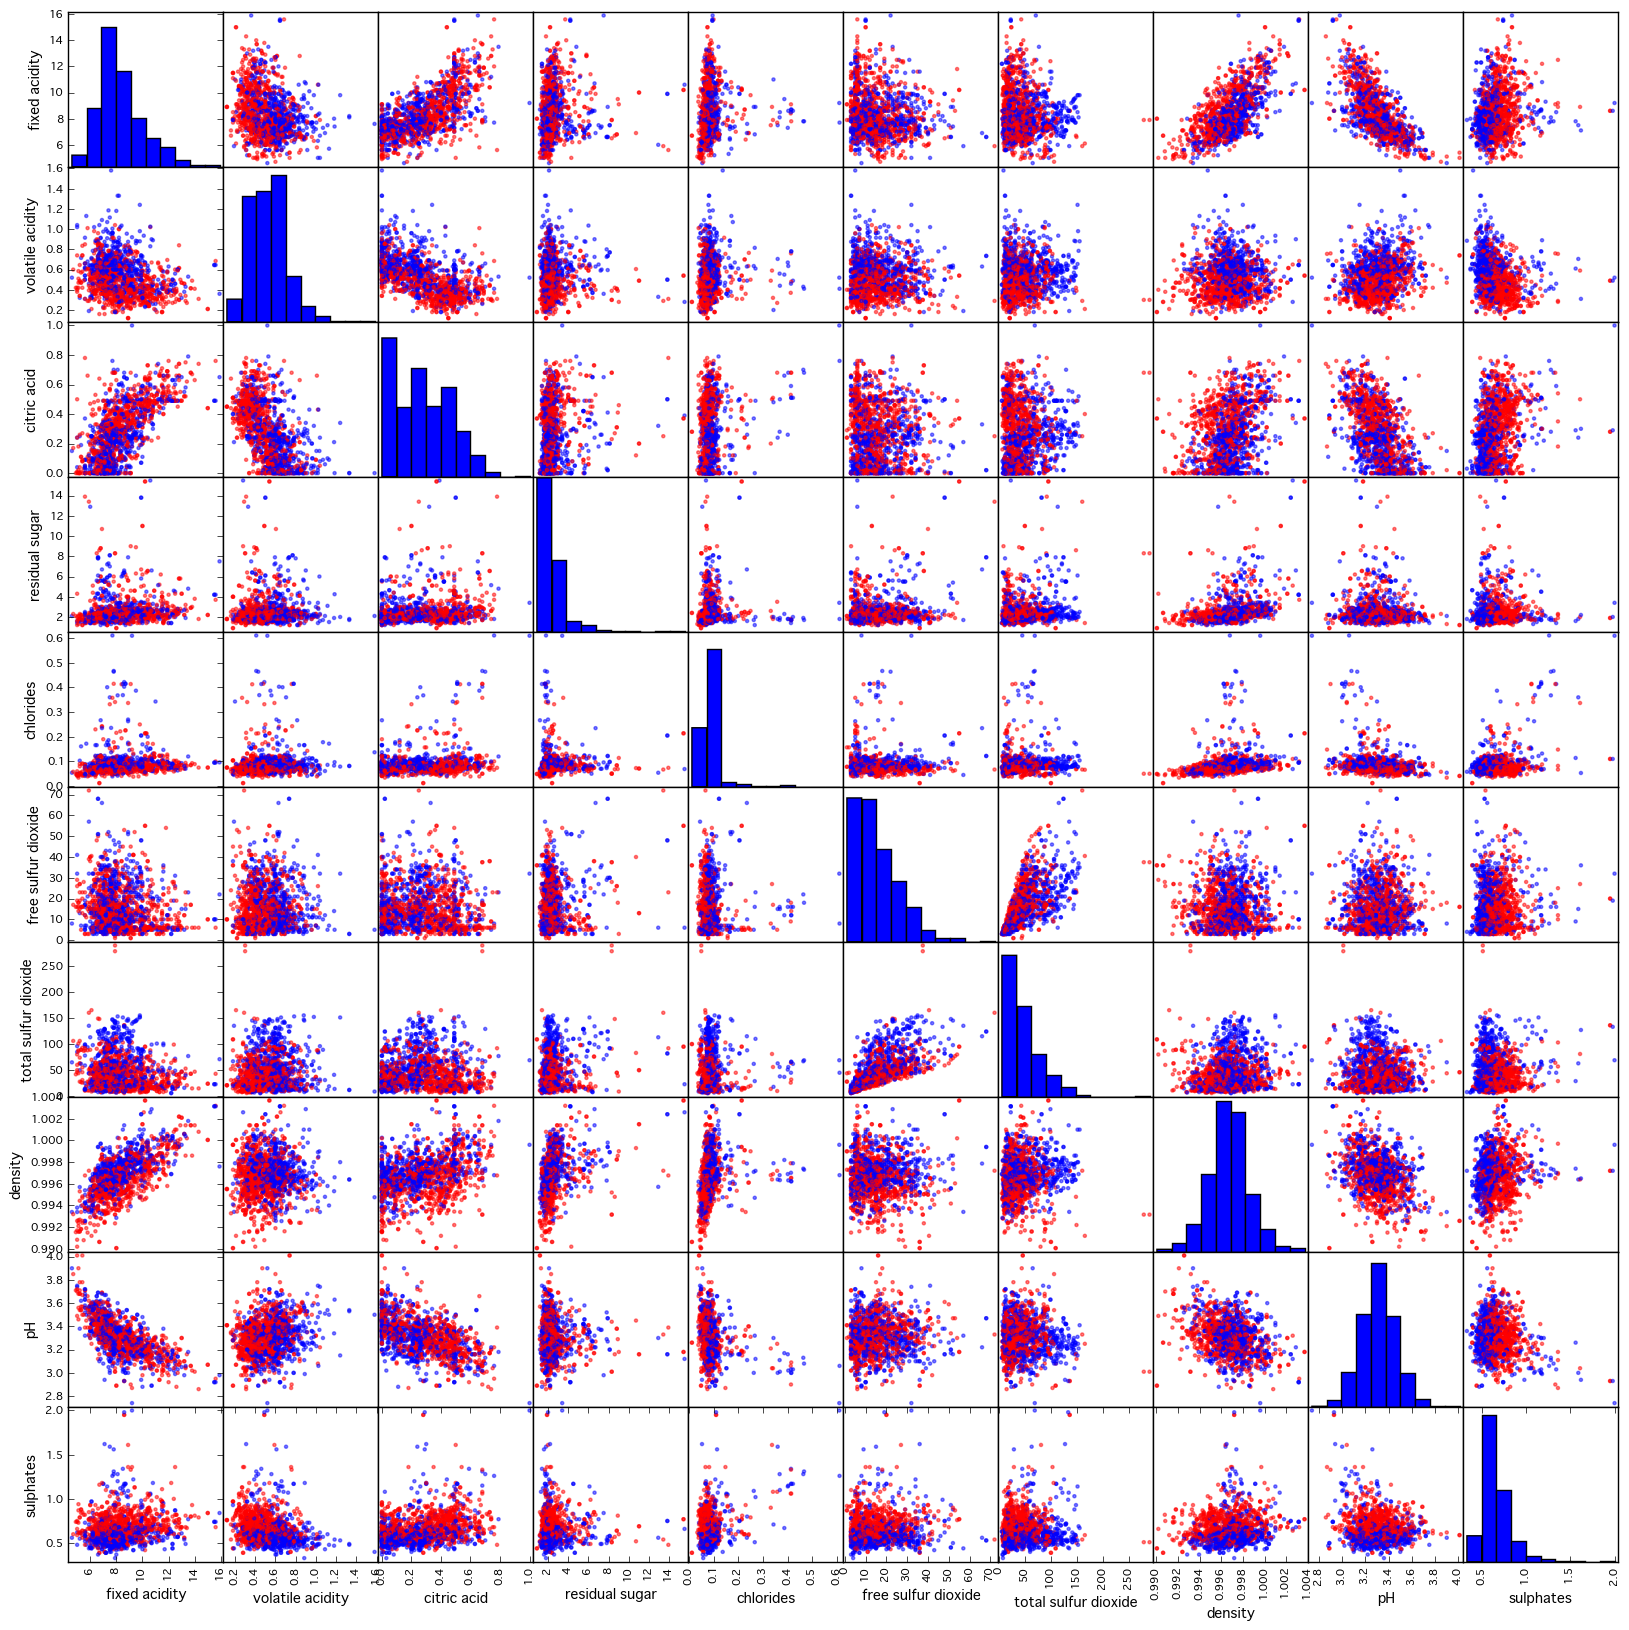

In [25]:
plotting.scatter_matrix(df1.dropna(axis=1)[df1.columns[:10]], figsize=(20, 20), color=colors, alpha=0.5) 
plt.show()

上図から、各変数と、quality の良し悪しとの関係がボンヤリとつかめてきたのではないでしょうか。続いて主成分分析をしてみます。

In [26]:
dfs = df1.apply(lambda x: (x-x.mean())/x.std(), axis=0).fillna(0) # データの正規化

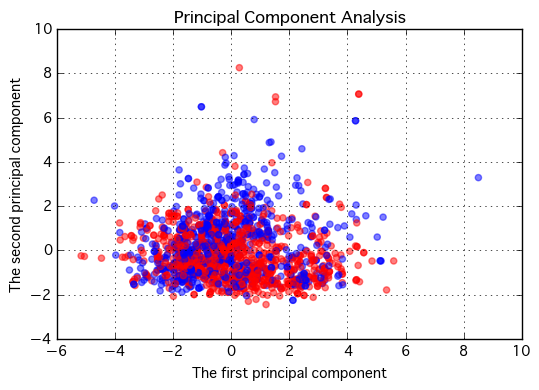

In [27]:
pca = PCA()
pca.fit(dfs.iloc[:, :10])
# データを主成分空間に写像 = 次元圧縮
feature = pca.transform(dfs.iloc[:, :10])
#plt.figure(figsize=(6, 6))
plt.scatter(feature[:, 0], feature[:, 1], alpha=0.5, color=colors)
plt.title("Principal Component Analysis")
plt.xlabel("The first principal component")
plt.ylabel("The second principal component")
plt.grid()
plt.show()

分かったような分からないような結果ですね。quality の良し悪しを分類・予測するのは簡単ではなさそうです。

<h3 STYLE="background: #c2edff;padding: 0.5em;"><a name="3">3. 説明変数と目的変数に分ける</a></h3>

ここまでで、ワインの品質を２群に分けました。次は、目的変数（ここでは、品質）と説明変数（それ以外の変数）に分けましょう。

In [28]:
X = dfs.iloc[:, :10] # 説明変数
y = df1.iloc[:, 12] # 目的変数

In [29]:
X.head() # 先頭５行を表示して確認

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates
0,-0.528194,0.961576,-1.391037,-0.453077,-0.243630,-0.466047,-0.379014,0.558100,1.288240,-0.579025
1,-0.298454,1.966827,-1.391037,0.043403,0.223805,0.872365,0.624168,0.028252,-0.719708,0.128910
2,-0.298454,1.296660,-1.185699,-0.169374,0.096323,-0.083643,0.228975,0.134222,-0.331073,-0.048074
3,1.654339,-1.384011,1.483689,-0.453077,-0.264878,0.107558,0.411372,0.664069,-0.978798,-0.461036
4,-0.528194,0.961576,-1.391037,-0.453077,-0.243630,-0.466047,-0.379014,0.558100,1.288240,-0.579025


In [30]:
pd.DataFrame(y).T # 目的変数を確認。縦に長いと見にくいので転置して表示。

,0,1,2,3,4,5,6,7,8,9,...,1589,1590,1591,1592,1593,1594,1595,1596,1597,1598
class,0,0,0,1,0,0,0,1,1,0,...,0,1,1,1,1,0,1,1,0,1


<h3 STYLE="background: #c2edff;padding: 0.5em;"><a name="4">4. 訓練データとテストデータに分ける</a></h3>

機械学習ではその性能評価をするために、既知データを訓練データ（教師データ、教師セットともいいます）とテストデータ（テストセットともいいます）に分割します。訓練データを用いて訓練（学習）して予測モデルを構築し、その予測モデル構築に用いなかったテストデータをどのくらい正しく予測できるかということで性能評価を行ないます。そのような評価方法を「交差検定」(cross-validation)と呼びます。ここでは、

* 訓練データ（全データの６０％）
    * __X_train__ : 訓練データの説明変数
    * __y_train__ : 訓練データの目的変数
* テストデータ（全データの４０％）
    * __X_test__ : テストデータの説明変数
    * __y_test__ : テストデータの目的変数
    
とし、__X_train__ と __y_train__ の関係を学習して __X_test__ から __y_test__ を予測することを目指します。

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4) # 訓練データ・テストデータへのランダムな分割

In [32]:
X_train.head() # 先頭５行を表示して確認

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates
274,-0.470759,0.682339,-0.467018,3.164129,0.011334,1.063567,1.444953,1.273395,0.446197,0.659862
1046,-0.413324,1.408354,-1.391037,-0.594928,-0.243630,1.637172,-0.044620,-0.332045,-0.007210,-0.225058
836,-0.930240,-1.384011,0.046326,-0.098449,-1.603443,1.923975,1.627350,-3.235611,-0.331073,-1.581934
451,0.046156,-0.881385,1.329686,-0.524002,6.916634,-0.657248,-0.622210,0.611085,-1.626523,2.370706
361,0.161027,-0.434607,0.200329,0.043403,-0.031160,0.489962,0.107377,0.770039,0.381425,1.485786


In [33]:
pd.DataFrame(y_train).T # 縦に長いと見にくいので転置して表示。

,274,1046,836,451,361,1577,1424,44,293,1295,...,43,1030,650,1143,520,1228,336,39,976,877
class,0,1,1,1,1,1,1,0,1,0,...,0,1,0,1,1,1,1,0,0,1


<h3 STYLE="background: #c2edff;padding: 0.5em;"><a name="5">5. ロジスティック回帰</a></h3>

機械学習モデルとして有名なものの一つとして、ロジスティック回帰があります。線形回帰分析が量的変数を予測するのに対して、ロジスティック回帰分析は発生確率を予測する手法です。基本的な考え方は線形回帰分析と同じなのですが、予測結果が 0 から 1 の間を取るように、数式やその前提に改良が加えられています。

In [34]:
clf = LogisticRegression() #モデルの生成
clf.fit(X_train, y_train) #学習

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [35]:
# 正解率 (train) : 学習に用いたデータをどのくらい正しく予測できるか
clf.score(X_train,y_train)

0.73201251303441084

In [36]:
# 正解率 (test) : 学習に用いなかったデータをどのくらい正しく予測できるか
clf.score(X_test,y_test)

0.73593750000000002

正解率の数字を出すだけなら以上でおしまいですが、具体的な予測結果を確認したい場合は次のようにします。

In [37]:
y_predict = clf.predict(X_test)

In [38]:
pd.DataFrame(y_predict).T

,0,1,2,3,4,5,6,7,8,9,...,630,631,632,633,634,635,636,637,638,639
0,1,1,1,0,0,0,0,0,1,0,...,0,0,0,1,0,1,1,1,1,0


In [39]:
# 予測結果と、正解（本当の答え）がどのくらい合っていたかを表す混合行列
pd.DataFrame(confusion_matrix(y_predict, y_test), index=['predicted 0', 'predicted 1'], columns=['real 0', 'real 1'])

,real 0,real 1
predicted 0,218,81
predicted 1,88,253


<h3 STYLE="background: #c2edff;padding: 0.5em;"><a name="6">6. いろんな機械学習手法を比較する</a></h3>

scikit-learn が用意している機械学習手法（分類器）はロジスティック回帰だけではありません。有名なものは SVM （サポートベクターマシン）などがあります。いろいろ試して、ベストなものを選択してみましょう。

まず、いろんな分類器を classifiers という名のリストの中に収納します。

In [40]:
names = ["Logistic Regression", "Nearest Neighbors", 
         "Linear SVM", "Polynomial SVM", "RBF SVM", "Sigmoid SVM", 
         "Decision Tree","Random Forest", "AdaBoost", "Naive Bayes", 
         "Linear Discriminant Analysis","Quadratic Discriminant Analysis"]

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(),
    SVC(kernel="linear"),
    SVC(kernel="poly"),
    SVC(kernel="rbf"),
    SVC(kernel="sigmoid"),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    LDA(),
    QDA()]

さきほど作成した教師データを使って、これらの分類器で順番に予測して、正解率（train）と正解率（test）を計算してみましょう。

In [41]:
result = []
for name, clf in zip(names, classifiers): # 指定した複数の分類機を順番に呼び出す
    clf.fit(X_train, y_train) # 学習
    score1 = clf.score(X_train, y_train) # 正解率（train）の算出
    score2 = clf.score(X_test, y_test) # 正解率（test）の算出
    result.append([score1, score2]) # 結果の格納

# test の正解率の大きい順に並べる
df_result = pd.DataFrame(result, columns=['train', 'test'], index=names).sort('test', ascending=False)

In [42]:
df_result # 結果の確認

,train,test
Random Forest,0.986444,0.768750
RBF SVM,0.791449,0.753125
Logistic Regression,0.732013,0.735938
Linear Discriminant Analysis,0.735141,0.734375
Linear SVM,0.732013,0.731250
AdaBoost,0.775808,0.723437
Decision Tree,1.000000,0.717187
Quadratic Discriminant Analysis,0.743483,0.715625
Polynomial SVM,0.761210,0.712500
Nearest Neighbors,0.779979,0.701562


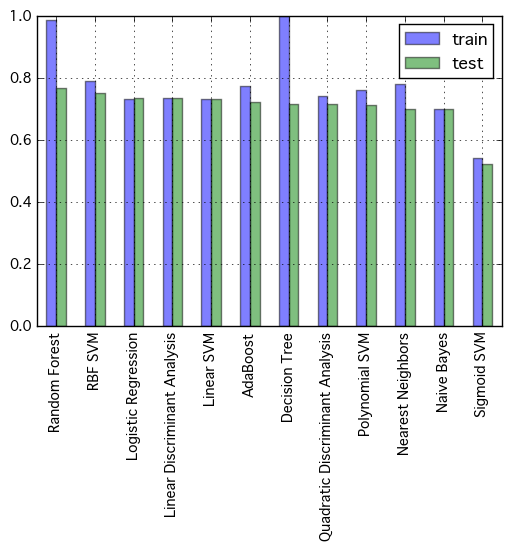

In [43]:
# 棒グラフの描画
df_result.plot(kind='bar', alpha=0.5, grid=True)

訓練データの作成はランダムに行なうので、作成のたびに正解率の数字は変わります。場合によっては、分類器の順序が前後することもあります。それでは適切な性能評価がしにくいので、教師データを何度も作り直して正解率を計算してみましょう。

In [44]:
result = []
for trial in range(20): # 20 回繰り返す
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4) # 訓練データ・テストデータの生成
    for name, clf in zip(names, classifiers): # 指定した複数の分類機を順番に呼び出す
        clf.fit(X_train, y_train) # 学習
        score1 = clf.score(X_train, y_train) # 正解率（train）の算出
        score2 = clf.score(X_test, y_test) # 正解率（test）の算出
        result.append([name, score1, score2]) # 結果の格納

df_result = pd.DataFrame(result, columns=['classifier', 'train', 'test']) # 今回はまだ並べ替えはしない

In [45]:
df_result # 結果の確認。同じ分類器の結果が複数回登場していることに注意。

,classifier,train,test
0,Logistic Regression,0.743483,0.725000
1,Nearest Neighbors,0.788321,0.693750
2,Linear SVM,0.744526,0.707812
3,Polynomial SVM,0.770594,0.692187
4,RBF SVM,0.791449,0.731250
5,Sigmoid SVM,0.552659,0.507812
6,Decision Tree,1.000000,0.701562
7,Random Forest,0.986444,0.753125
8,AdaBoost,0.805005,0.723437
9,Naive Bayes,0.689260,0.698438


In [46]:
# 分類器 (classifier) 毎にグループ化して正解率の平均を計算し、test の正解率の平均の大きい順に並べる
df_result_mean = df_result.groupby('classifier').mean().sort('test', ascending=False)

In [47]:
df_result_mean # 結果の確認

,train,test
classifier,,
Random Forest,0.986757,0.757734
RBF SVM,0.794421,0.743594
Logistic Regression,0.736184,0.730156
Linear Discriminant Analysis,0.735193,0.727578
Linear SVM,0.735610,0.725703
AdaBoost,0.794578,0.722266
Decision Tree,1.000000,0.719609
Polynomial SVM,0.757977,0.703359
Quadratic Discriminant Analysis,0.725287,0.701484


In [48]:
# エラーバーの表示に用いる目的で、標準偏差を計算する
errors = df_result.groupby('classifier').std()

In [49]:
errors # 結果の確認

,train,test
classifier,,
AdaBoost,0.008783,0.011000
Decision Tree,0.000000,0.017826
Linear Discriminant Analysis,0.011809,0.016009
Linear SVM,0.011594,0.013915
Logistic Regression,0.011636,0.015201
Naive Bayes,0.014581,0.017374
Nearest Neighbors,0.011295,0.016033
Polynomial SVM,0.011417,0.022064
Quadratic Discriminant Analysis,0.013304,0.021707


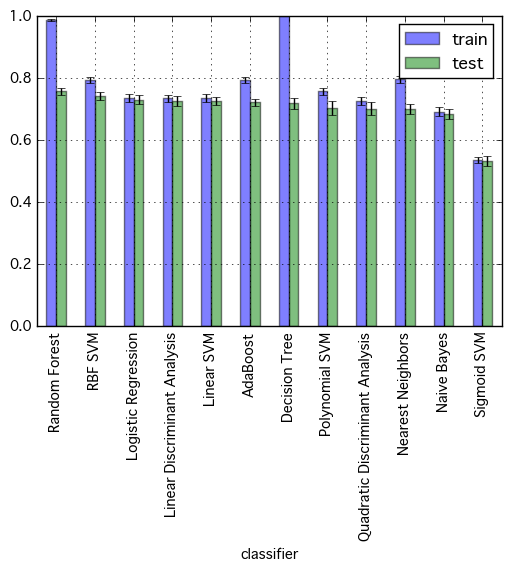

In [50]:
# 平均値と標準偏差を用いて棒グラフを描画
df_result_mean.plot(kind='bar', alpha=0.5, grid=True, yerr=errors)

以上、様々な分類器を用いて、ワインの品質の善し悪しを予測しました。それぞれの分類器にはそれぞれのパラメーターがありますが、上の例では全てデフォルト値を使っています。上手にパラメーターをチューニングすれば、もっと良い予測性能が出せるかもしれません。ですが今回はここまでとさせていただきます。興味があったらぜひ調べてみてください。

<h4 style="padding: 0.25em 0.5em;color: #494949;background: transparent;border-left: solid 5px #7db4e6;"><a name="4">練習5.1</a></h4>

白ワインのデータ(https://raw.githubusercontent.com/chemo-wakate/tutorial-6th/master/beginner/data/winequality-white.txt) についても同様に機械学習による二値分類を行なってください。

In [51]:
# 練習5.1